In [1]:
import neo
import numpy as np
import matplotlib.pyplot as plt
import plot_utils as u
from pathlib import Path

In [2]:
ctx_lfp_dir = Path("../../sim_res/Cortical_Pop")
interneuron_lfp_dir = Path("../../sim_res/Interneuron_Pop")

In [3]:
gaba_data_file_ctx = ctx_lfp_dir / "Ctx_GABAa_i.mat"
ampa_data_file_ctx = ctx_lfp_dir / "Ctx_AMPA_i.mat"
gaba_data_file_int = interneuron_lfp_dir / "Interneuron_GABAa_i.mat"
ampa_data_file_int = interneuron_lfp_dir / "Interneuron_AMPA_i.mat"

In [4]:
gaba_data_ctx = neo.NeoMatlabIO(gaba_data_file_ctx).read()
ampa_data_ctx = neo.NeoMatlabIO(ampa_data_file_ctx).read()
gaba_data_int = neo.NeoMatlabIO(gaba_data_file_int).read()
ampa_data_int = neo.NeoMatlabIO(ampa_data_file_int).read()

In [5]:
tt = gaba_data_ctx[0].segments[0].analogsignals[0].times

In [6]:
electrode_count = 3
electrode_distance = 0.4
excluded_radius = 0.06

max_radius = 1
distances_ctx = np.random.uniform(low=excluded_radius, high=max_radius, size=(100,))
angles_ctx = np.random.uniform(0, 2 * np.pi, size=(100,))
x_ctx = distances_ctx * np.cos(angles_ctx)
y_ctx = distances_ctx * np.sin(angles_ctx)

distances_int = np.random.uniform(low=excluded_radius, high=max_radius, size=(100,))
angles_int = np.random.uniform(0, 2 * np.pi, size=(100,))
x_int = distances_int * np.cos(angles_int)
y_int = distances_int * np.sin(angles_int)

if electrode_count % 2 != 0:
    electrode_y = [0]
    for i in range(electrode_count - 1):
        electrode_y.append(((1 + np.floor(i / 2)) * (-1) ** i) * electrode_distance)
else:
    electrode_y = [electrode_distance / 2, -electrode_distance / 2]
    for i in range(electrode_count - 2):
        electrode_y.append((-1) ** i * (np.floor(i / 2) + 1 + 0.5) * electrode_distance)
electrode_y = sorted(electrode_y)

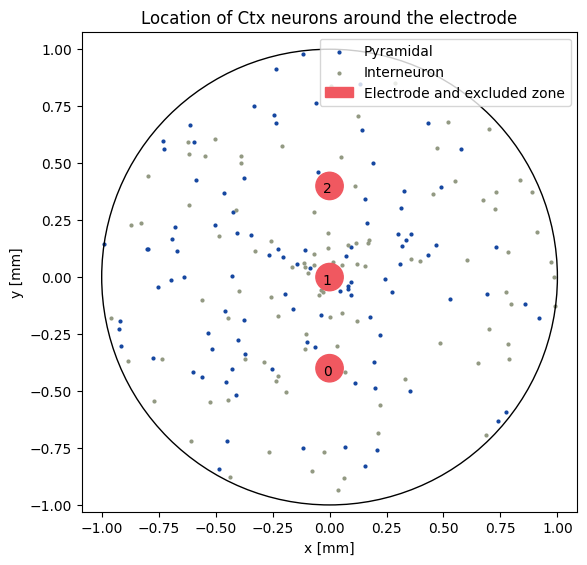

In [7]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.set_aspect(1)
plot_ctx = ax.scatter(x_ctx, y_ctx, s=4, color="#1446A0")
plot_int = ax.scatter(x_int, y_int, s=4, color="#929982")
circle = plt.Circle((0, 0), max_radius, fill=False, color="black")
for i, y in enumerate(electrode_y):
    plot_exc = plt.Circle((0, y), excluded_radius, fill=True, color="#F05860")
    ax.add_artist(plot_exc)
    ax.text(0 - excluded_radius / 2, y - excluded_radius / 2, str(i))
ax.add_artist(circle)
ax.set_xlabel("x [mm]")
ax.set_ylabel("y [mm]")
ax.set_title("Location of Ctx neurons around the electrode")
ax.legend([plot_ctx, plot_int, plot_exc], ["Pyramidal", "Interneuron", "Electrode and excluded zone"])

In [8]:
all_currents_ctx = (
    gaba_data_ctx[0].segments[0].analogsignals[0].as_array() + 
    ampa_data_ctx[0].segments[0].analogsignals[0].as_array()
    )
all_currents_int = (
    gaba_data_int[0].segments[0].analogsignals[0].as_array() +
    ampa_data_int[0].segments[0].analogsignals[0].as_array()
)

In [9]:
# Units:
# all_currents: nA
# sigma: S / m
# distances: mm
# ---
# lfp: microvolt

sigma = 0.27
lfp_ctx = np.sum(all_currents_ctx / distances_ctx / (4 * np.pi * sigma), axis=1)
lfp_int = np.sum(all_currents_int / distances_int / (4 * np.pi * sigma), axis=1)
lfp_both = lfp_ctx + lfp_int

Text(0, 0.5, 'Voltage [$\\mu$V]')

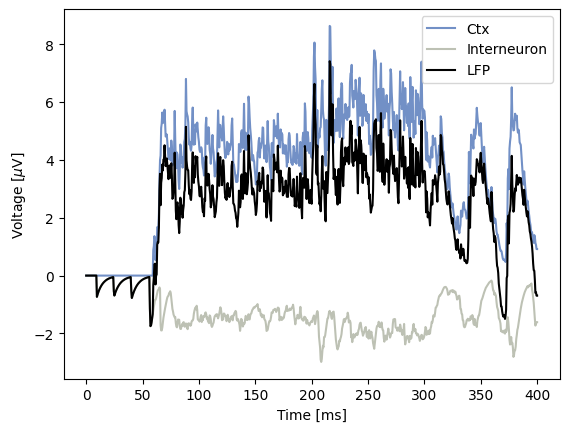

In [10]:
plt.figure()
plt.plot(tt, lfp_ctx, color="#1446A0", alpha=0.6)
plt.plot(tt, lfp_int, color="#929982", alpha=0.6)
plt.plot(tt, lfp_both, color="black") 
plt.legend(["Ctx", "Interneuron", "LFP"])
plt.xlabel("Time [ms]")
plt.ylabel("Voltage [$\mu$V]")

In [11]:
electrode_lfp = []
for y_e in electrode_y:
    distances_ctx_e = np.sqrt(x_ctx ** 2 + (y_ctx - y_e) ** 2)
    distances_int_e = np.sqrt(x_int ** 2 + (y_int - y_e) ** 2)
    distances_ctx_e[distances_ctx_e < excluded_radius] = excluded_radius
    distances_int_e[distances_int_e < excluded_radius] = excluded_radius
    lfp_ctx = np.sum(all_currents_ctx / distances_ctx_e / (4 * np.pi * sigma), axis=1)
    lfp_int = np.sum(all_currents_int / distances_int_e / (4 * np.pi * sigma), axis=1)
    lfp_both = lfp_ctx + lfp_int
    electrode_lfp.append(lfp_both)

Text(0, 0.5, 'Voltage [$\\mu$V]')

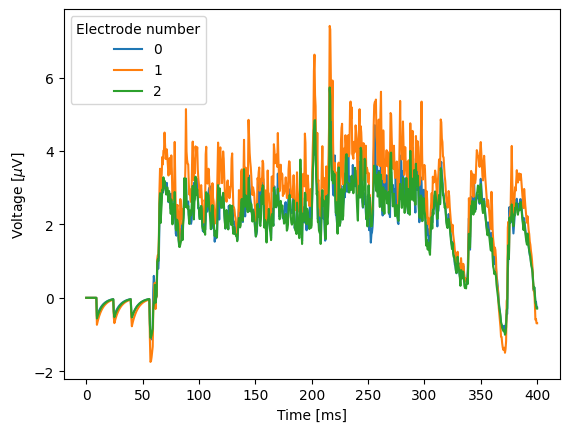

In [12]:
legend = []
plt.figure()
for i, elfp in enumerate(electrode_lfp):
    plt.plot(tt, elfp)
    legend.append(i)
plt.legend(legend, title="Electrode number")
plt.xlabel("Time [ms]")
plt.ylabel("Voltage [$\mu$V]")